# Khai báo Thư Viện

In [ ]:
import os, sys, glob, random, shutil, json, time
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix


# Tải tập dữ liệu

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dimensi0n/afhq-512")

print("Path to dataset files:", path)

100%|██████████| 6.48G/6.48G [00:59<00:00, 118MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dimensi0n/afhq-512/versions/1


In [ ]:
# Thư mục gốc chứa cat/dog/wild
base_dir = os.path.join(path)
print("Base dir (dataset gốc):", base_dir)

# Thư mục lưu sau khi chia train/val/test
output_dir = "/content/gdrive/MyDrive/afhq_split"
os.makedirs(output_dir, exist_ok=True)


Base dir (dataset gốc): /root/.cache/kagglehub/datasets/dimensi0n/afhq-512/versions/1


# EDA Dataset

In [ ]:
classes = sorted([d for d in os.listdir(base_dir)
                 if os.path.isdir(os.path.join(base_dir, d))])
print(f"Các lớp: {classes}")

Các lớp: ['cat', 'dog', 'wild']


In [ ]:
counts = []
for cname in classes:
    cpath = os.path.join(base_dir, cname)
    # Đếm số file ảnh
    num = len([f for f in os.listdir(cpath) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    counts.append((cname, num))

counts_df = pd.DataFrame(counts, columns=["Class","Count"])
display(counts_df)

Class  Count
0   cat   5558
1   dog   5169
2  wild   5076

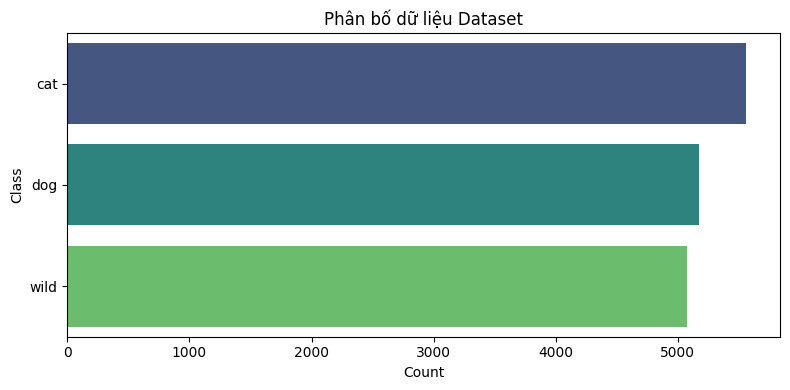

In [ ]:
counts_df = pd.DataFrame(counts, columns=["Class", "Count"])
plt.figure(figsize=(8, 4))
sns.barplot(data=counts_df, y="Class", x="Count", hue="Class", legend=False, palette="viridis")
plt.title("Phân bố dữ liệu Dataset")
plt.tight_layout()
plt.show()

# Hiển thị mỗi lớp một ảnh

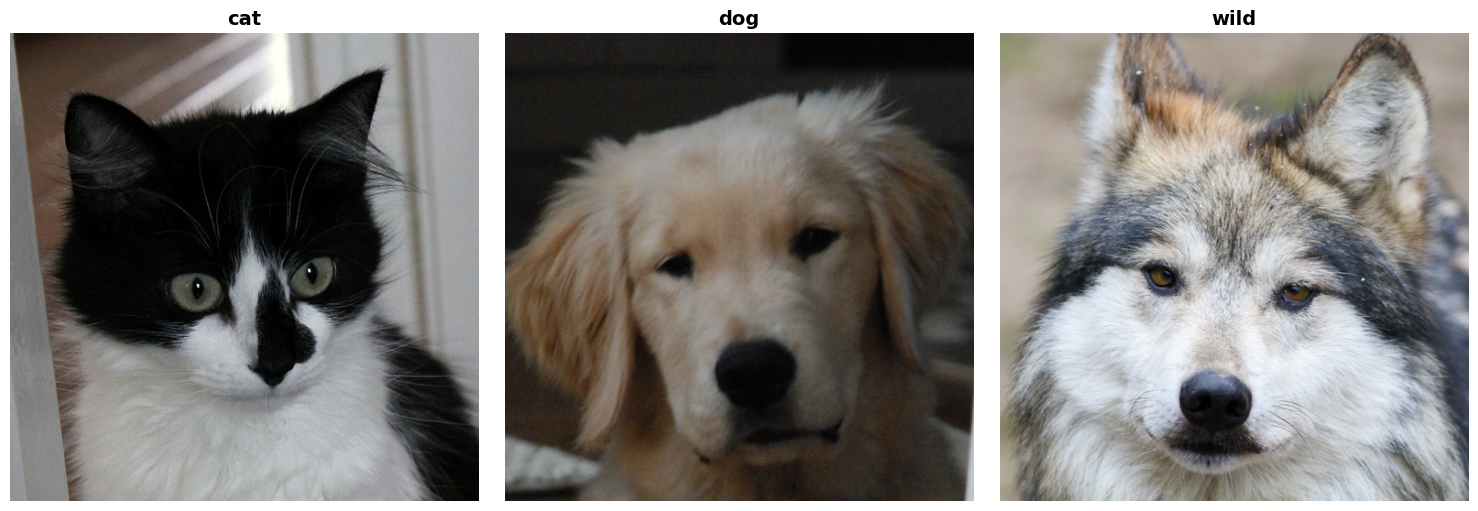

In [ ]:
from PIL import Image

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, cls in enumerate(classes):
    cls_path = os.path.join(base_dir, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png'))]
    if imgs:
        img = Image.open(os.path.join(cls_path, imgs[0])).convert('RGB')
        axes[i].imshow(img)
        axes[i].set_title(cls, fontsize=14, fontweight='bold')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

# Chia tập dữ liệu

In [ ]:
TRAIN_DIR = f"{output_dir}/train"
TEST_DIR = f"{output_dir}/test"

In [ ]:
if os.path.exists(TRAIN_DIR) and os.path.exists(TEST_DIR):
    print("Dataset đã được chia trước đó. Skip.")
else:
    print("Đang chia dataset...")
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        files = [os.path.join(cls_path, f) for f in os.listdir(cls_path)
                if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        train_files, test_files = train_test_split(files, test_size=0.2,
                                                   random_state=42)

        # Copy vào thư mục train
        train_cls_dir = os.path.join(TRAIN_DIR, cls)
        os.makedirs(train_cls_dir, exist_ok=True)
        for f in train_files:
            shutil.copy(f, train_cls_dir)

        # Copy vào thư mục test
        test_cls_dir = os.path.join(TEST_DIR, cls)
        os.makedirs(test_cls_dir, exist_ok=True)
        for f in test_files:
            shutil.copy(f, test_cls_dir)

        print(f"  {cls}: Train={len(train_files)}, Test={len(test_files)}")

Đang chia dataset...
  cat: Train=4446, Test=1112
  dog: Train=4135, Test=1034
  wild: Train=4060, Test=1016


# Minh họa mẫu

Ảnh mẫu: /content/gdrive/MyDrive/afhq_split/train/cat/5352.png


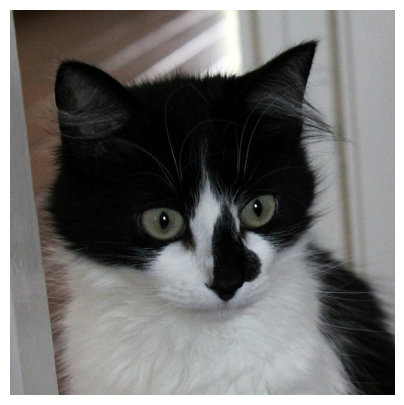

In [ ]:
sample_cls = classes[0]
sample_dir = os.path.join(TRAIN_DIR, sample_cls)
sample_imgs = [f for f in os.listdir(sample_dir) if f.endswith(('.jpg', '.png'))]
sample_img_path = os.path.join(sample_dir, sample_imgs[0])

print(f"Ảnh mẫu: {sample_img_path}")
plt.figure(figsize=(5, 5))
plt.imshow(plt.imread(sample_img_path))
plt.axis('off')
plt.show()


Số keypoints: 330


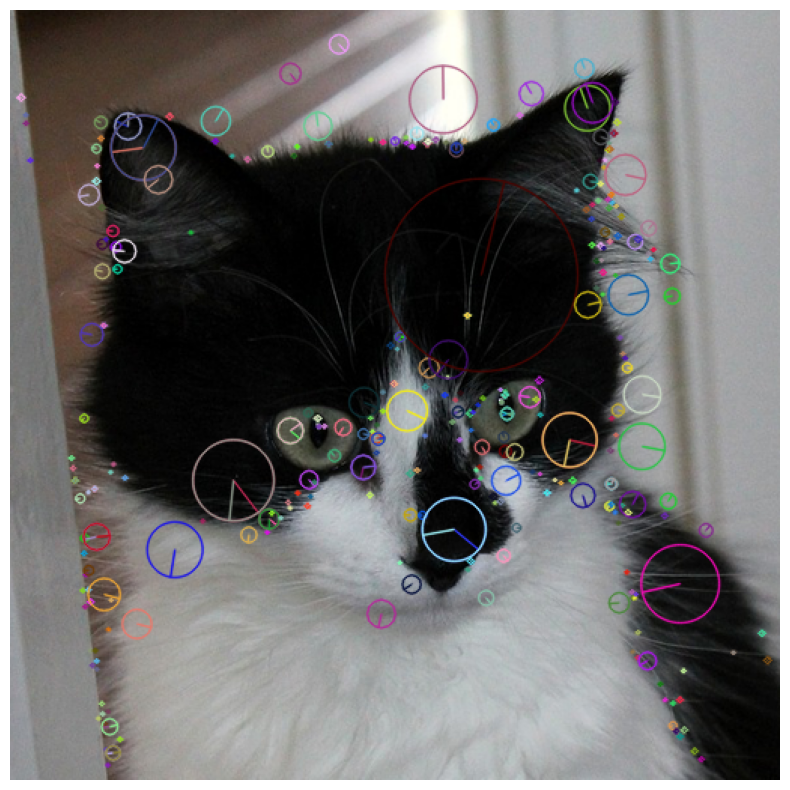

In [ ]:
sift = cv2.SIFT_create(nfeatures=700)
img = cv2.imread(sample_img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
keypoints, desc = sift.detectAndCompute(gray, None)
print(f"Số keypoints: {len(keypoints)}")
plt.figure(figsize=(10, 10))
img_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_keypoints_rgb = cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB)
plt.imshow(img_keypoints_rgb)
plt.axis('off')
plt.show()

# Trích xuất đặc trưng

In [ ]:
def load_image_paths_and_labels(root_dir):
    """
    root_dir: thư mục train/ hoặc val/ hoặc test/
    return:
        - image_paths: list[str]
        - labels: list[str]
    """
    image_paths = []
    labels = []

    classes = sorted(os.listdir(root_dir))  # ['cat', 'dog', 'wild', ...]
    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        for fname in os.listdir(cls_dir):
            fpath = os.path.join(cls_dir, fname)
            if fpath.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_paths.append(fpath)
                labels.append(cls)

    return image_paths, labels


In [ ]:
def extract_sift_descriptors(image_paths, max_keypoints=700):
    """
    Trích descriptor SIFT cho từng ảnh.
    Trả về:
        - descriptors_per_image: list[np.ndarray or None]
        - all_descriptors: np.ndarray (gộp tất cả để train KMeans)
    """
    sift = cv2.SIFT_create(nfeatures=max_keypoints)
    descriptors_per_image = []
    all_desc_list = []

    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            descriptors_per_image.append(None)
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, desc = sift.detectAndCompute(gray, None)

        if desc is None:
            descriptors_per_image.append(None)
            continue

        # L2 normalize từng descriptor (optional nhưng tốt)
        norms = np.linalg.norm(desc, axis=1, keepdims=True) + 1e-7
        desc_norm = desc / norms

        descriptors_per_image.append(desc_norm)
        all_desc_list.append(desc_norm)

    if len(all_desc_list) == 0:
        raise ValueError("Không trích được descriptor nào, kiểm tra lại ảnh/dataset.")

    all_descriptors = np.vstack(all_desc_list)
    return descriptors_per_image, all_descriptors


In [ ]:
from sklearn.cluster import MiniBatchKMeans

def build_codebook(all_descriptors, n_clusters=200, batch_size=1000):
    """
    Train MiniBatchKMeans trên toàn bộ descriptor.
    """
    kmeans = MiniBatchKMeans(
        n_clusters=n_clusters,
        batch_size=batch_size,
        random_state=42,
        verbose=1
    )
    kmeans.fit(all_descriptors)
    return kmeans


In [ ]:
def build_bovw_features(descriptors_per_image, kmeans, n_clusters):
    """
    Với mỗi ảnh:
        - gán mỗi descriptor vào 1 cluster
        - đếm histogram (length = n_clusters)
        - L2 normalize histogram
    """
    n_images = len(descriptors_per_image)
    X = np.zeros((n_images, n_clusters), dtype=np.float32)

    for i, desc in enumerate(descriptors_per_image):
        if desc is None:
            # Ảnh không có keypoint → histogram toàn 0
            continue

        # Dự đoán cluster cho từng descriptor
        cluster_idx = kmeans.predict(desc)
        hist, _ = np.histogram(cluster_idx, bins=np.arange(n_clusters+1))
        hist = hist.astype(np.float32)

        # L2 normalize histogram
        norm = np.linalg.norm(hist) + 1e-7
        hist /= norm

        X[i, :] = hist

    return X


In [ ]:
TRAIN_DIR = os.path.join(output_dir, "train")
TEST_DIR  = os.path.join(output_dir, "test")

# 1) Load path + label
train_paths, y_train = load_image_paths_and_labels(TRAIN_DIR)
test_paths,  y_test  = load_image_paths_and_labels(TEST_DIR)

print("Số ảnh train:", len(train_paths))
print("Số ảnh test:", len(test_paths))

# 2) Trích SIFT cho train, val, test
train_desc_per_img, train_all_desc = extract_sift_descriptors(train_paths, max_keypoints=700)
test_desc_per_img,  _              = extract_sift_descriptors(test_paths,  max_keypoints=700)

print("Tổng descriptor train:", train_all_desc.shape)

# 3) Train codebook trên descriptor train
N_CLUSTERS = 300
kmeans = build_codebook(train_all_desc, n_clusters=N_CLUSTERS, batch_size=2000)

# 4) Convert sang BoVW feature
X_train = build_bovw_features(train_desc_per_img, kmeans, N_CLUSTERS)
X_test  = build_bovw_features(test_desc_per_img,  kmeans, N_CLUSTERS)

y_train = np.array(y_train)
y_test  = np.array(y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:",  X_test.shape)


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Minibatch step 2126/400770: mean batch inertia: 0.27183746337890624, ewa inertia: 0.2827340865687529
Minibatch step 2127/400770: mean batch inertia: 0.27193170166015623, ewa inertia: 0.28272869575967075
Minibatch step 2128/400770: mean batch inertia: 0.2690849609375, ewa inertia: 0.28272188700676887
Minibatch step 2129/400770: mean batch inertia: 0.26622802734375, ewa inertia: 0.28271365593101816
Minibatch step 2130/400770: mean batch inertia: 0.2719686889648438, ewa inertia: 0.28270829377571643
Minibatch step 2131/400770: mean batch inertia: 0.26993426513671875, ewa inertia: 0.2827019190399349
Minibatch step 2132/400770: mean batch inertia: 0.2696377258300781, ewa inertia: 0.2826953995007774
Minibatch step 2133/400770: mean batch inertia: 0.2737480773925781, ewa inertia: 0.2826909344399885
Minibatch step 2134/400770: mean batch inertia: 0.26842449951171876, ewa inertia: 0.2826838149355798
Minibatch step 2135/400770: mean batch i

Tìm tham số tốt nhất cho Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
RF - best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
RF - best CV accuracy: 0.7938453396803716
=== Random Forest trên tập test ===
              precision    recall  f1-score   support

         cat       0.80      0.78      0.79      1112
         dog       0.77      0.79      0.78      1034
        wild       0.83      0.82      0.82      1016

    accuracy                           0.80      3162
   macro avg       0.80      0.80      0.80      3162
weighted avg       0.80      0.80      0.80      3162

Confusion matrix:
[[872 156  84]
 [129 817  88]
 [ 89  94 833]]


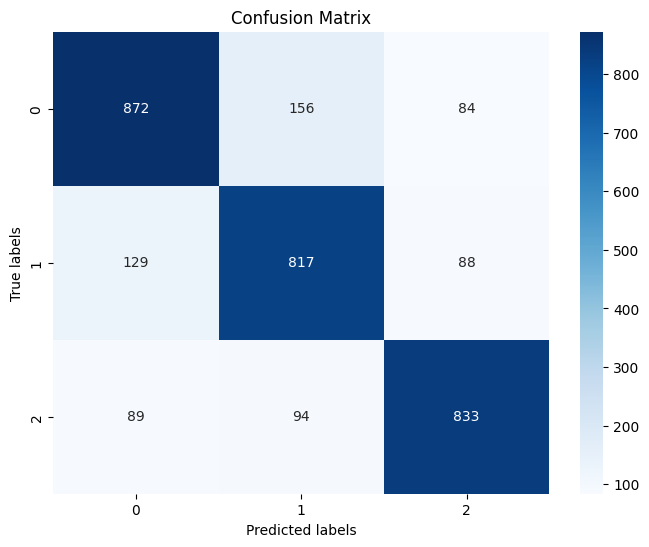

In [ ]:
from sklearn.model_selection import GridSearchCV


rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

param_grid_rf = {
    "n_estimators": [200, 500],
    "max_depth": [None, 20, 40],
    "min_samples_leaf": [1, 2, 5]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("Tìm tham số tốt nhất cho Random Forest...")
grid_rf.fit(X_train, y_train)

print("RF - best params:", grid_rf.best_params_)
print("RF - best CV accuracy:", grid_rf.best_score_)

# best_rf = grid_rf.best_estimator_


# Đánh giá trên test
y_pred_rf = best_rf.predict(X_test)
print("=== Random Forest trên tập test ===")
print(classification_report(y_test, y_pred_rf))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



Tìm tham số tốt nhất cho SVM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
SVM - best params: {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
SVM - best CV accuracy: 0.8559448829349856
=== SVM trên tập test ===
              precision    recall  f1-score   support

         cat       0.87      0.88      0.87      1112
         dog       0.84      0.86      0.85      1034
        wild       0.90      0.87      0.88      1016

    accuracy                           0.87      3162
   macro avg       0.87      0.87      0.87      3162
weighted avg       0.87      0.87      0.87      3162

Confusion matrix:
[[973 100  39]
 [ 84 886  64]
 [ 56  72 888]]


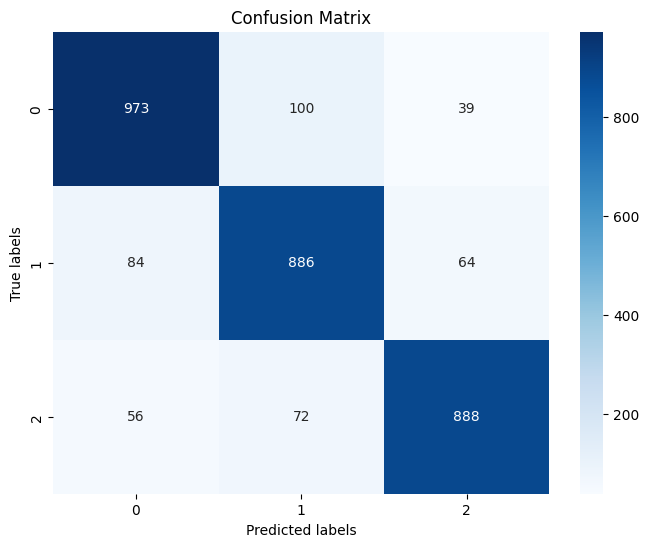

In [ ]:
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # chuẩn hoá histogram trước khi vào SVM
    ("svm", SVC())
])

param_grid_svm = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": [1e-3, 1e-4],
    "svm__kernel": ["rbf"]
}

grid_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("Tìm tham số tốt nhất cho SVM...")
grid_svm.fit(X_train, y_train)

print("SVM - best params:", grid_svm.best_params_)
print("SVM - best CV accuracy:", grid_svm.best_score_)

best_svm = grid_svm.best_estimator_

# Đánh giá trên test
y_pred_svm = best_svm.predict(X_test)
print("=== SVM trên tập test ===")
print(classification_report(y_test, y_pred_svm))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_svm))

# vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



# So sánh hai mô hình

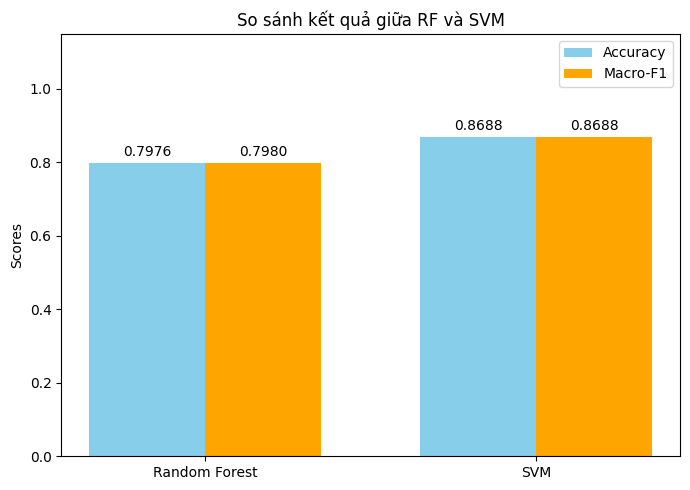

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='macro')
svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='macro')

models = ["Random Forest", "SVM"]
accs = [rf_acc, svm_acc]
f1s  = [rf_f1, svm_f1]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(7,5))

rects1 = ax.bar(x - width/2, accs, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1s,  width, label='Macro-F1', color='orange')

ax.set_ylabel('Scores')
ax.set_title('So sánh kết quả giữa RF và SVM')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1.15)
plt.tight_layout()
plt.show()

# Task
So sánh và phân tích kết quả dự đoán của mô hình Random Forest và SVM trên tập kiểm tra, bao gồm:
1. Xác định số lượng ảnh được phân loại đúng bởi cả hai mô hình.
2. Xác định số lượng ảnh được phân loại sai bởi cả hai mô hình.
3. Xác định số lượng ảnh được Random Forest phân loại đúng nhưng SVM phân loại sai.
4. Xác định số lượng ảnh được SVM phân loại đúng nhưng Random Forest phân loại sai.
5. Tổng hợp và hiển thị các thống kê trên.

## So sánh dự đoán của hai mô hình

### Subtask:
So sánh dự đoán của mô hình Random Forest và SVM với nhãn thực tế trên tập kiểm tra (y_test) để xác định các trường hợp: đúng ở cả hai, sai ở cả hai, đúng ở RF và sai ở SVM, sai ở RF và đúng ở SVM.


**Reasoning**:
To compare the predictions of both models with the true labels, I will create boolean arrays for correct predictions for each model and then use logical operations to identify the indices for the four desired scenarios: both correct, both incorrect, RF correct/SVM incorrect, and SVM correct/RF incorrect. This directly addresses instructions 1-6.



In [ ]:
import numpy as np

# 1. Mảng boolean cho biết khi nào dự đoán của Random Forest khớp với nhãn thực tế
rf_correct = (y_pred_rf == y_test)

# 2. Mảng boolean cho biết khi nào dự đoán của SVM khớp với nhãn thực tế
svm_correct = (y_pred_svm == y_test)

# 3. Chỉ mục mà cả hai mô hình đều dự đoán đúng
both_correct_indices = np.where(rf_correct & svm_correct)[0]
print(f"Cả hai mô hình dự đoán đúng: {len(both_correct_indices)} trường hợp")

# 4. Chỉ mục mà cả hai mô hình đều dự đoán sai
both_incorrect_indices = np.where(~rf_correct & ~svm_correct)[0]
print(f"Cả hai mô hình dự đoán sai: {len(both_incorrect_indices)} trường hợp")

# 5. Chỉ mục mà Random Forest dự đoán đúng và SVM dự đoán sai
rf_correct_svm_incorrect_indices = np.where(rf_correct & ~svm_correct)[0]
print(f"RF đúng, SVM sai: {len(rf_correct_svm_incorrect_indices)} trường hợp")

# 6. Chỉ mục mà SVM dự đoán đúng và Random Forest dự đoán sai
svm_correct_rf_incorrect_indices = np.where(svm_correct & ~rf_correct)[0]
print(f"SVM đúng, RF sai: {len(svm_correct_rf_incorrect_indices)} trường hợp")

Cả hai mô hình dự đoán đúng: 2392 trường hợp
Cả hai mô hình dự đoán sai: 285 trường hợp
RF đúng, SVM sai: 130 trường hợp
SVM đúng, RF sai: 355 trường hợp


## Phân tích và minh họa các trường hợp khác biệt

### Subtask:
Tùy chọn hiển thị một vài ví dụ ảnh cho từng loại trường hợp (RF đúng/SVM sai, SVM đúng/RF sai, cả hai đều sai) để minh họa sự khác biệt trong hiệu suất dự đoán giữa hai mô hình.


**Reasoning**:
I need to display example images for the 'RF correct/SVM incorrect' scenario. First, I'll select a random index from `rf_correct_svm_incorrect_indices`, then retrieve the image path, true label, and both model predictions, and finally display this information along with the image.




--- RF correct, SVM incorrect ---
Ảnh: /content/gdrive/MyDrive/afhq_split/test/cat/4964.png
Nhãn thực tế: cat
RF dự đoán: cat (ĐÚNG)
SVM dự đoán: dog (SAI)


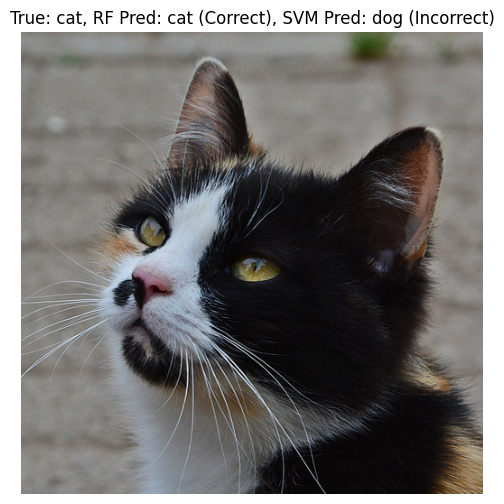

In [ ]:
import random
from PIL import Image

# --- Case 1: RF correct, SVM incorrect ---
print("\n--- RF correct, SVM incorrect ---")
if len(rf_correct_svm_incorrect_indices) > 0:
    idx = random.choice(rf_correct_svm_incorrect_indices)
    img_path = test_paths[idx]
    true_label = y_test[idx]
    rf_pred = y_pred_rf[idx]
    svm_pred = y_pred_svm[idx]

    print(f"Ảnh: {img_path}")
    print(f"Nhãn thực tế: {true_label}")
    print(f"RF dự đoán: {rf_pred} (ĐÚNG)")
    print(f"SVM dự đoán: {svm_pred} (SAI)")

    plt.figure(figsize=(6, 6))
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"True: {true_label}, RF Pred: {rf_pred} (Correct), SVM Pred: {svm_pred} (Incorrect)")
    plt.axis('off')
    plt.show()
else:
    print("Không có trường hợp RF đúng, SVM sai để hiển thị.")

**Reasoning**:
I need to display example images for the 'SVM correct/RF incorrect' scenario. I will select a random index from `svm_correct_rf_incorrect_indices`, then retrieve the image path, true label, and both model predictions, and finally display this information along with the image.




--- SVM correct, RF incorrect ---
Ảnh: /content/gdrive/MyDrive/afhq_split/test/cat/4633.png
Nhãn thực tế: cat
RF dự đoán: dog (SAI)
SVM dự đoán: cat (ĐÚNG)


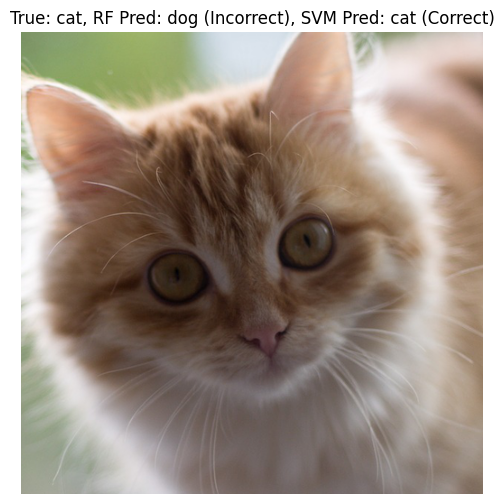

In [ ]:
print("\n--- SVM correct, RF incorrect ---")
if len(svm_correct_rf_incorrect_indices) > 0:
    idx = random.choice(svm_correct_rf_incorrect_indices)
    img_path = test_paths[idx]
    true_label = y_test[idx]
    rf_pred = y_pred_rf[idx]
    svm_pred = y_pred_svm[idx]

    print(f"Ảnh: {img_path}")
    print(f"Nhãn thực tế: {true_label}")
    print(f"RF dự đoán: {rf_pred} (SAI)")
    print(f"SVM dự đoán: {svm_pred} (ĐÚNG)")

    plt.figure(figsize=(6, 6))
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"True: {true_label}, RF Pred: {rf_pred} (Incorrect), SVM Pred: {svm_pred} (Correct)")
    plt.axis('off')
    plt.show()
else:
    print("Không có trường hợp SVM đúng, RF sai để hiển thị.")

**Reasoning**:
I need to display example images for the 'both incorrect' scenario. I will select a random index from `both_incorrect_indices`, then retrieve the image path, true label, and both model predictions, and finally display this information along with the image.




--- Cả hai mô hình đều dự đoán sai ---
Ảnh: /content/gdrive/MyDrive/afhq_split/test/wild/4215.png
Nhãn thực tế: wild
RF dự đoán: cat (SAI)
SVM dự đoán: dog (SAI)


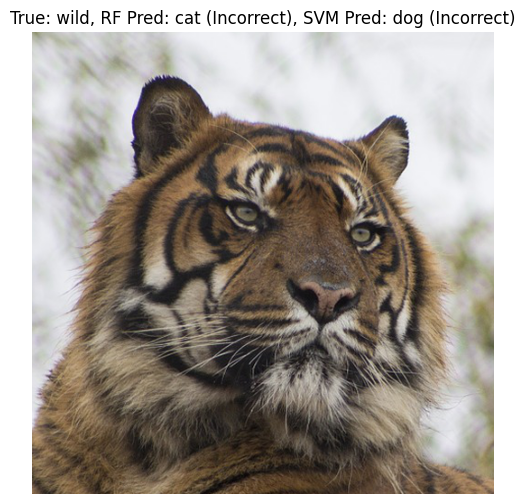

In [ ]:
print("\n--- Cả hai mô hình đều dự đoán sai ---")
if len(both_incorrect_indices) > 0:
    idx = random.choice(both_incorrect_indices)
    img_path = test_paths[idx]
    true_label = y_test[idx]
    rf_pred = y_pred_rf[idx]
    svm_pred = y_pred_svm[idx]

    print(f"Ảnh: {img_path}")
    print(f"Nhãn thực tế: {true_label}")
    print(f"RF dự đoán: {rf_pred} (SAI)")
    print(f"SVM dự đoán: {svm_pred} (SAI)")

    plt.figure(figsize=(6, 6))
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"True: {true_label}, RF Pred: {rf_pred} (Incorrect), SVM Pred: {svm_pred} (Incorrect)")
    plt.axis('off')
    plt.show()
else:
    print("Không có trường hợp cả hai mô hình đều sai để hiển thị.")

## Final Task

### Subtask:
Tóm tắt và phân tích kết quả so sánh giữa hai mô hình, nêu bật điểm mạnh và điểm yếu của từng mô hình dựa trên các trường hợp dự đoán đã được phân loại.


## Summary:

### Q&A
1.  **Số lượng ảnh được phân loại đúng bởi cả hai mô hình là bao nhiêu?**
    Cả hai mô hình đã phân loại đúng 2392 trường hợp.

2.  **Số lượng ảnh được phân loại sai bởi cả hai mô hình là bao nhiêu?**
    Cả hai mô hình đã phân loại sai 285 trường hợp.

3.  **Số lượng ảnh được Random Forest phân loại đúng nhưng SVM phân loại sai là bao nhiêu?**
    Có 130 trường hợp Random Forest phân loại đúng nhưng SVM phân loại sai.

4.  **Số lượng ảnh được SVM phân loại đúng nhưng Random Forest phân loại sai là bao nhiêu?**
    Có 355 trường hợp SVM phân loại đúng nhưng Random Forest phân loại sai.

### Data Analysis Key Findings
*   Random Forest và SVM thể hiện hiệu suất tốt khi cả hai cùng dự đoán đúng 2392 trường hợp.
*   Random Forest vượt trội hơn SVM trong 130 trường hợp, nơi RF dự đoán đúng còn SVM dự đoán sai.
*   Tuy nhiên, SVM lại thể hiện khả năng mạnh hơn ở 355 trường hợp, nơi SVM dự đoán đúng còn Random Forest dự đoán sai. Điều này cho thấy SVM có thể xử lý tốt hơn một số mẫu dữ liệu cụ thể mà Random Forest gặp khó khăn.
*   Có 285 trường hợp mà cả hai mô hình đều dự đoán sai, cho thấy đây là những mẫu dữ liệu khó hoặc mơ hồ mà cả hai thuật toán đều không thể giải quyết hiệu quả.
*   Các ví dụ minh họa cho thấy sự khác biệt trong lỗi dự đoán. Chẳng hạn, trong một trường hợp, Random Forest dự đoán đúng 'cat' trong khi SVM dự đoán sai là 'dog'. Ngược lại, SVM có thể dự đoán đúng 'cat' khi Random Forest dự đoán sai 'dog'. Đặc biệt, có những ảnh 'wild' mà cả hai mô hình đều dự đoán sai ('cat' và 'dog').

### Insights or Next Steps
*   Để cải thiện hiệu suất tổng thể, có thể xem xét việc kết hợp hai mô hình (ensemble learning) hoặc nghiên cứu các đặc trưng (features) mà mỗi mô hình xử lý tốt hơn để xây dựng một mô hình mạnh mẽ hơn.
*   Nghiên cứu sâu hơn 285 trường hợp mà cả hai mô hình đều dự đoán sai để tìm hiểu nguyên nhân gốc rễ. Điều này có thể giúp xác định các loại ảnh khó hoặc các vấn đề về chất lượng dữ liệu, từ đó cải thiện quy trình tiền xử lý hoặc thu thập thêm dữ liệu.
